<a href="https://colab.research.google.com/github/RamSaw/deep-unsupervised-learning/blob/HW_03/HW3_T01_A.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np
import torch
import random
import os
import matplotlib.pyplot as plt
import matplotlib
import torch 
import torch.nn as nn
from tqdm.auto import tqdm, trange
from torch.distributions import Normal, MultivariateNormal, Uniform
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
from torch.autograd import Variable
import pickle
from torch.utils.data import DataLoader
import torchvision
from matplotlib import pyplot as plt

In [2]:
def make_reproducible(seed, make_cuda_reproducible):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if make_cuda_reproducible:
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

SEED = 2341
make_reproducible(SEED, False)
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(DEVICE)

cuda


In [0]:
def sample_data_1():
    count = 100000
    rand = np.random.RandomState(0)
    return [[1.0, 2.0]] + rand.randn(count, 2) * [[5.0, 1.0]]
def sample_data_2():
    count = 100000
    rand = np.random.RandomState(0)
    return [[1.0, 2.0]] + (rand.randn(count, 2) * [[5.0, 1.0]]).dot([[np.sqrt(2) / 2, np.sqrt(2) / 2], [-np.sqrt(2) / 2, np.sqrt(2) / 2]])

torch.Size([100000, 2])


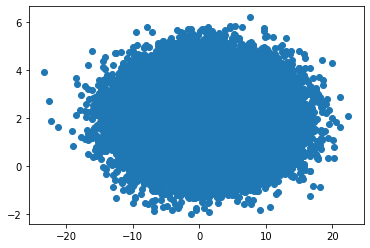

In [4]:
X1 = torch.from_numpy(sample_data_1()).float()
print(X1.shape)
plt.scatter(X1[:, 0], X1[:, 1])

torch.Size([100000, 2])


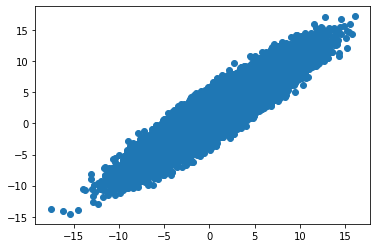

In [5]:
X2 = torch.from_numpy(sample_data_2()).float()
print(X2.shape)
plt.scatter(X2[:, 0], X2[:, 1])

In [0]:
class IsotropicNormal(nn.Module):
    def __init__(self):
        super(IsotropicNormal, self).__init__()
        self.ffn = nn.Sequential(
          nn.Linear(2, 256),
          nn.ReLU(),
          nn.Linear(256, 128),
          nn.ReLU()
        )
        self.mu_linear = nn.Linear(128, 2)
        self.log_var_linear = nn.Linear(128, 2)
            
    def forward(self, x):
        hidden = self.ffn(x)
        mu = self.mu_linear(hidden)
        log_var = self.log_var_linear(hidden)
        var = torch.exp(log_var)
        return mu, var

In [0]:
class NormalIdenticalEntries(nn.Module):
    def __init__(self, n_layers=3, n_features=128):
        super(NormalIdenticalEntries, self).__init__()
        self.ffn = nn.Sequential(
          nn.Linear(2, 256),
          nn.ReLU(),
          nn.Linear(256, 128),
          nn.ReLU()
        )
        self.mu_linear = nn.Linear(128, 2)
        self.log_var_linear = nn.Linear(128, 1)
            
    def forward(self, x):
        hidden = self.ffn(x)
        mu = self.mu_linear(hidden)
        log_var = self.log_var_linear(hidden) * torch.ones([1, 2]).to(DEVICE)
        var = torch.exp(log_var)
        return mu, var

In [0]:
class VAE(nn.Module):
    def __init__(self, config):
        super(VAE, self).__init__()
        self.encoder = IsotropicNormal()
        if config == 1:
          self.decoder = IsotropicNormal()
        else:
          self.decoder = NormalIdenticalEntries()
        self.prior = MultivariateNormal(torch.zeros(2), torch.diag_embed(torch.ones(2)))
    
    def forward(self, x):
        mu_z, var_z = self.encode(x)
        z = self.sample_normal(mu_z, var_z)
        mu_x, var_x = self.decode(z)
        return mu_z, var_z, z, mu_x, var_x
      
    def loss(self, x):
        mu_z, var_z, z, mu_x, var_x = self.forward(x)
        nll = torch.sum(-0.5 * (torch.log(np.pi * 2 * var_x) + torch.pow(x - mu_x, 2) / var_x), dim=1, keepdim=True)
        nll = -torch.sum(nll, dim=1, keepdim=True)
        kl_divergence = 1.0 + torch.log(var_z) - torch.pow(mu_z, 2) - var_z
        kl_divergence = -0.5 * torch.sum(kl_divergence, dim=1, keepdim=True)
        return nll, kl_divergence

    def encode(self, x):
        return self.encoder(x)

    def sample(self, n):
        z = self.prior.rsample((n,)).to(DEVICE)
        mu_x, var_x = self.decode(z)
        x = self.sample_normal(mu_x, var_x)
        return x, mu_x, var_x

    def sample_normal(self, mu, var):
      return mu + torch.randn(mu.shape).cuda() * torch.sqrt(var)

    def decode(self, z):
        return self.decoder(z)

In [0]:
def train(vae, data, epochs_cnt=7, lr=2e-3, batch_size=256):
    optimizer = torch.optim.Adam(vae.parameters(), lr=lr)
    dataloader = DataLoader(data, batch_size=batch_size, shuffle=True)

    nll_values = []
    kl_divergence_values = []
    vlb_values = []

    for i in trange(epochs_cnt):
        for batch in dataloader:
            batch = batch.to(DEVICE)
            nll, kl_divergence = vae.loss(batch)
            loss = torch.mean(nll + kl_divergence)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            nll_values.append(torch.mean(nll).detach().item() / 2.0 / np.log(2))
            kl_divergence_values.append(torch.mean(kl_divergence).detach().item())
            vlb_values.append(torch.mean(-loss).detach().item())
    return nll_values, kl_divergence_values, vlb_values

In [10]:
VAE1_1 = VAE(config=1).to(DEVICE)
NLL1_1, KL_DIVERGENCE1_1, VLB1_1 = train(VAE1_1, X1)

In [0]:
def plot_losses(losses, label):
    plt.plot(losses, label=label)
    plt.legend()
    plt.show()

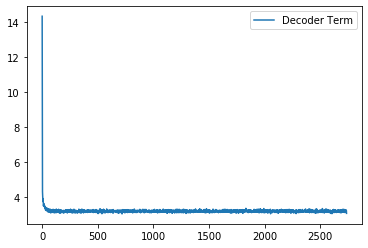

In [12]:
plot_losses(NLL1_1, 'Decoder Term')

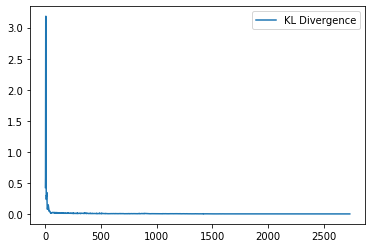

In [13]:
plot_losses(KL_DIVERGENCE1_1, 'KL Divergence')

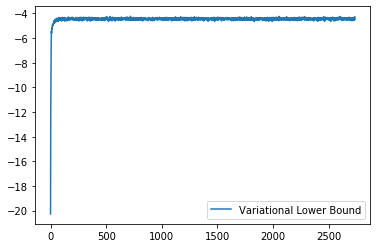

In [14]:
plot_losses(VLB1_1, 'Variational Lower Bound')

In [0]:
def draw_vae_samples(vae_model, n):
    x, mu_x, var_x = vae_model.sample(n)
    x = x.cpu().detach().numpy()
    mu_x = mu_x.cpu().detach().numpy()
    plt.scatter(x[:, 0], x[:, 1], marker='.', label="Samples From Full Generation Path")
    plt.scatter(mu_x[:, 0], mu_x[:, 1], marker='.', label="Without Decoder Noise")
    plt.legend()

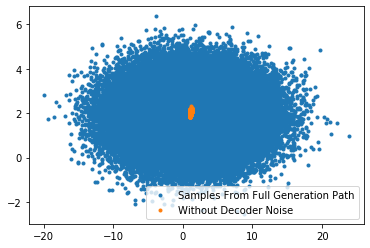

In [16]:
draw_vae_samples(VAE1_1, 100000)

In [17]:
VAE2_1 = VAE(config=1).to(DEVICE)
NLL2_1, KL_DIVERGENCE2_1, VLB2_1 = train(VAE2_1, X2)

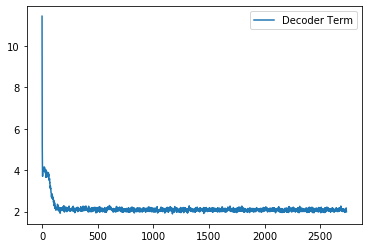

In [18]:
plot_losses(NLL2_1, 'Decoder Term')

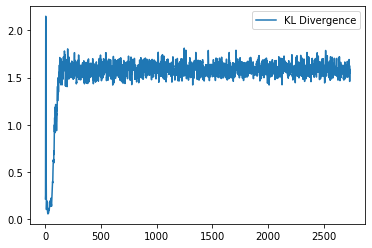

In [19]:
plot_losses(KL_DIVERGENCE2_1, 'KL Divergence')

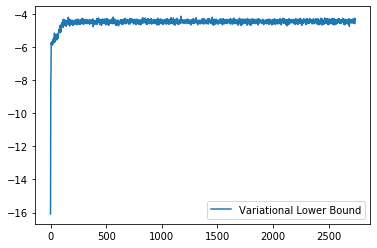

In [20]:
plot_losses(VLB2_1, 'Variational Lower Bound')

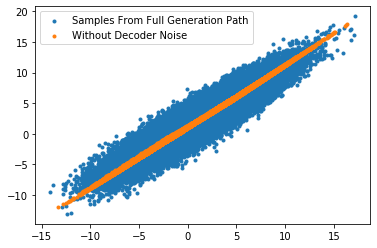

In [21]:
draw_vae_samples(VAE2_1, 100000)

In [22]:
VAE1_2 = VAE(config=2).to(DEVICE)
NLL1_2, KL_DIVERGENCE1_2, VLB1_2 = train(VAE1_2, X1)

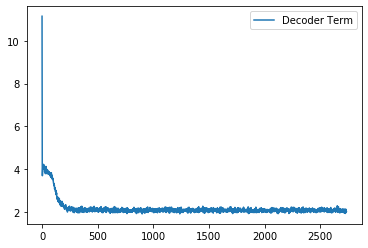

In [23]:
plot_losses(NLL1_2, 'Decoder Term')

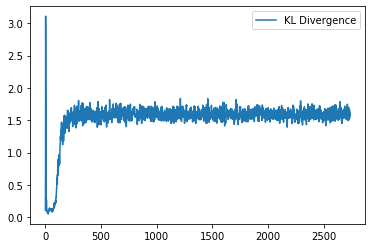

In [24]:
plot_losses(KL_DIVERGENCE1_2, 'KL Divergence')

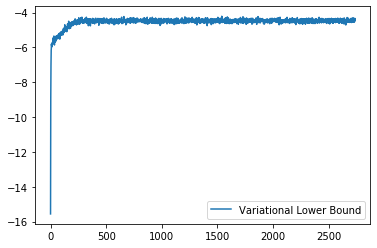

In [25]:
plot_losses(VLB1_2, 'Variational Lower Bound')

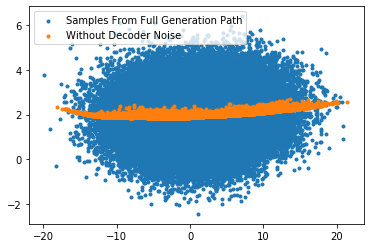

In [26]:
draw_vae_samples(VAE1_2, 100000)

In [27]:
VAE2_2 = VAE(config=2).to(DEVICE)
NLL2_2, KL_DIVERGENCE2_2, VLB2_2 = train(VAE2_2, X2)

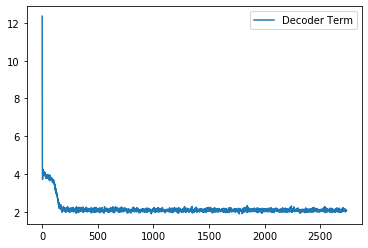

In [28]:
plot_losses(NLL2_2, 'Decoder Term')

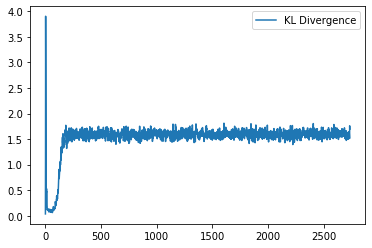

In [29]:
plot_losses(KL_DIVERGENCE2_2, 'KL Divergence')

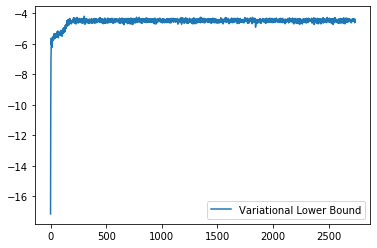

In [30]:
plot_losses(VLB2_2, 'Variational Lower Bound')

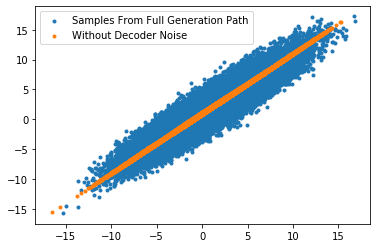

In [31]:
draw_vae_samples(VAE2_2, 100000)

In [33]:
print('Final KL Divergences')
print(f'Data 1, Config 1: {KL_DIVERGENCE1_1[-1]}')
print(f'Data 2, Config 1: {KL_DIVERGENCE2_1[-1]}')
print(f'Data 1, Config 2: {KL_DIVERGENCE1_2[-1]}')
print(f'Data 2, Config 2: {KL_DIVERGENCE2_2[-1]}')

Final KL Divergences
Data 1, Config 1: 5.396027336246334e-05
Data 2, Config 1: 1.6202458143234253
Data 1, Config 2: 1.5425952672958374
Data 2, Config 2: 1.6946810483932495


#Ответ на вопрос

VAE с конфигурацией 1 на данных 1 не использует латентное пространство, так как KL дивергенция между $p(z|x) \approx q(z|x)$ и $p(z)$ (а это равно взаимной информации между X и Z) очень маленькое. Это можно видеть и на рисунке. Все пространство в Z сжимается в почти точку и все распределение моделируется исключительно шумом. В других случаях мы видем, что взаимная информация высока, а значит X и латентное пространство действительно "коррелируют".